In [27]:
import os
import numpy as np 
from PIL import Image
import tensorflow_hub as hub    
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

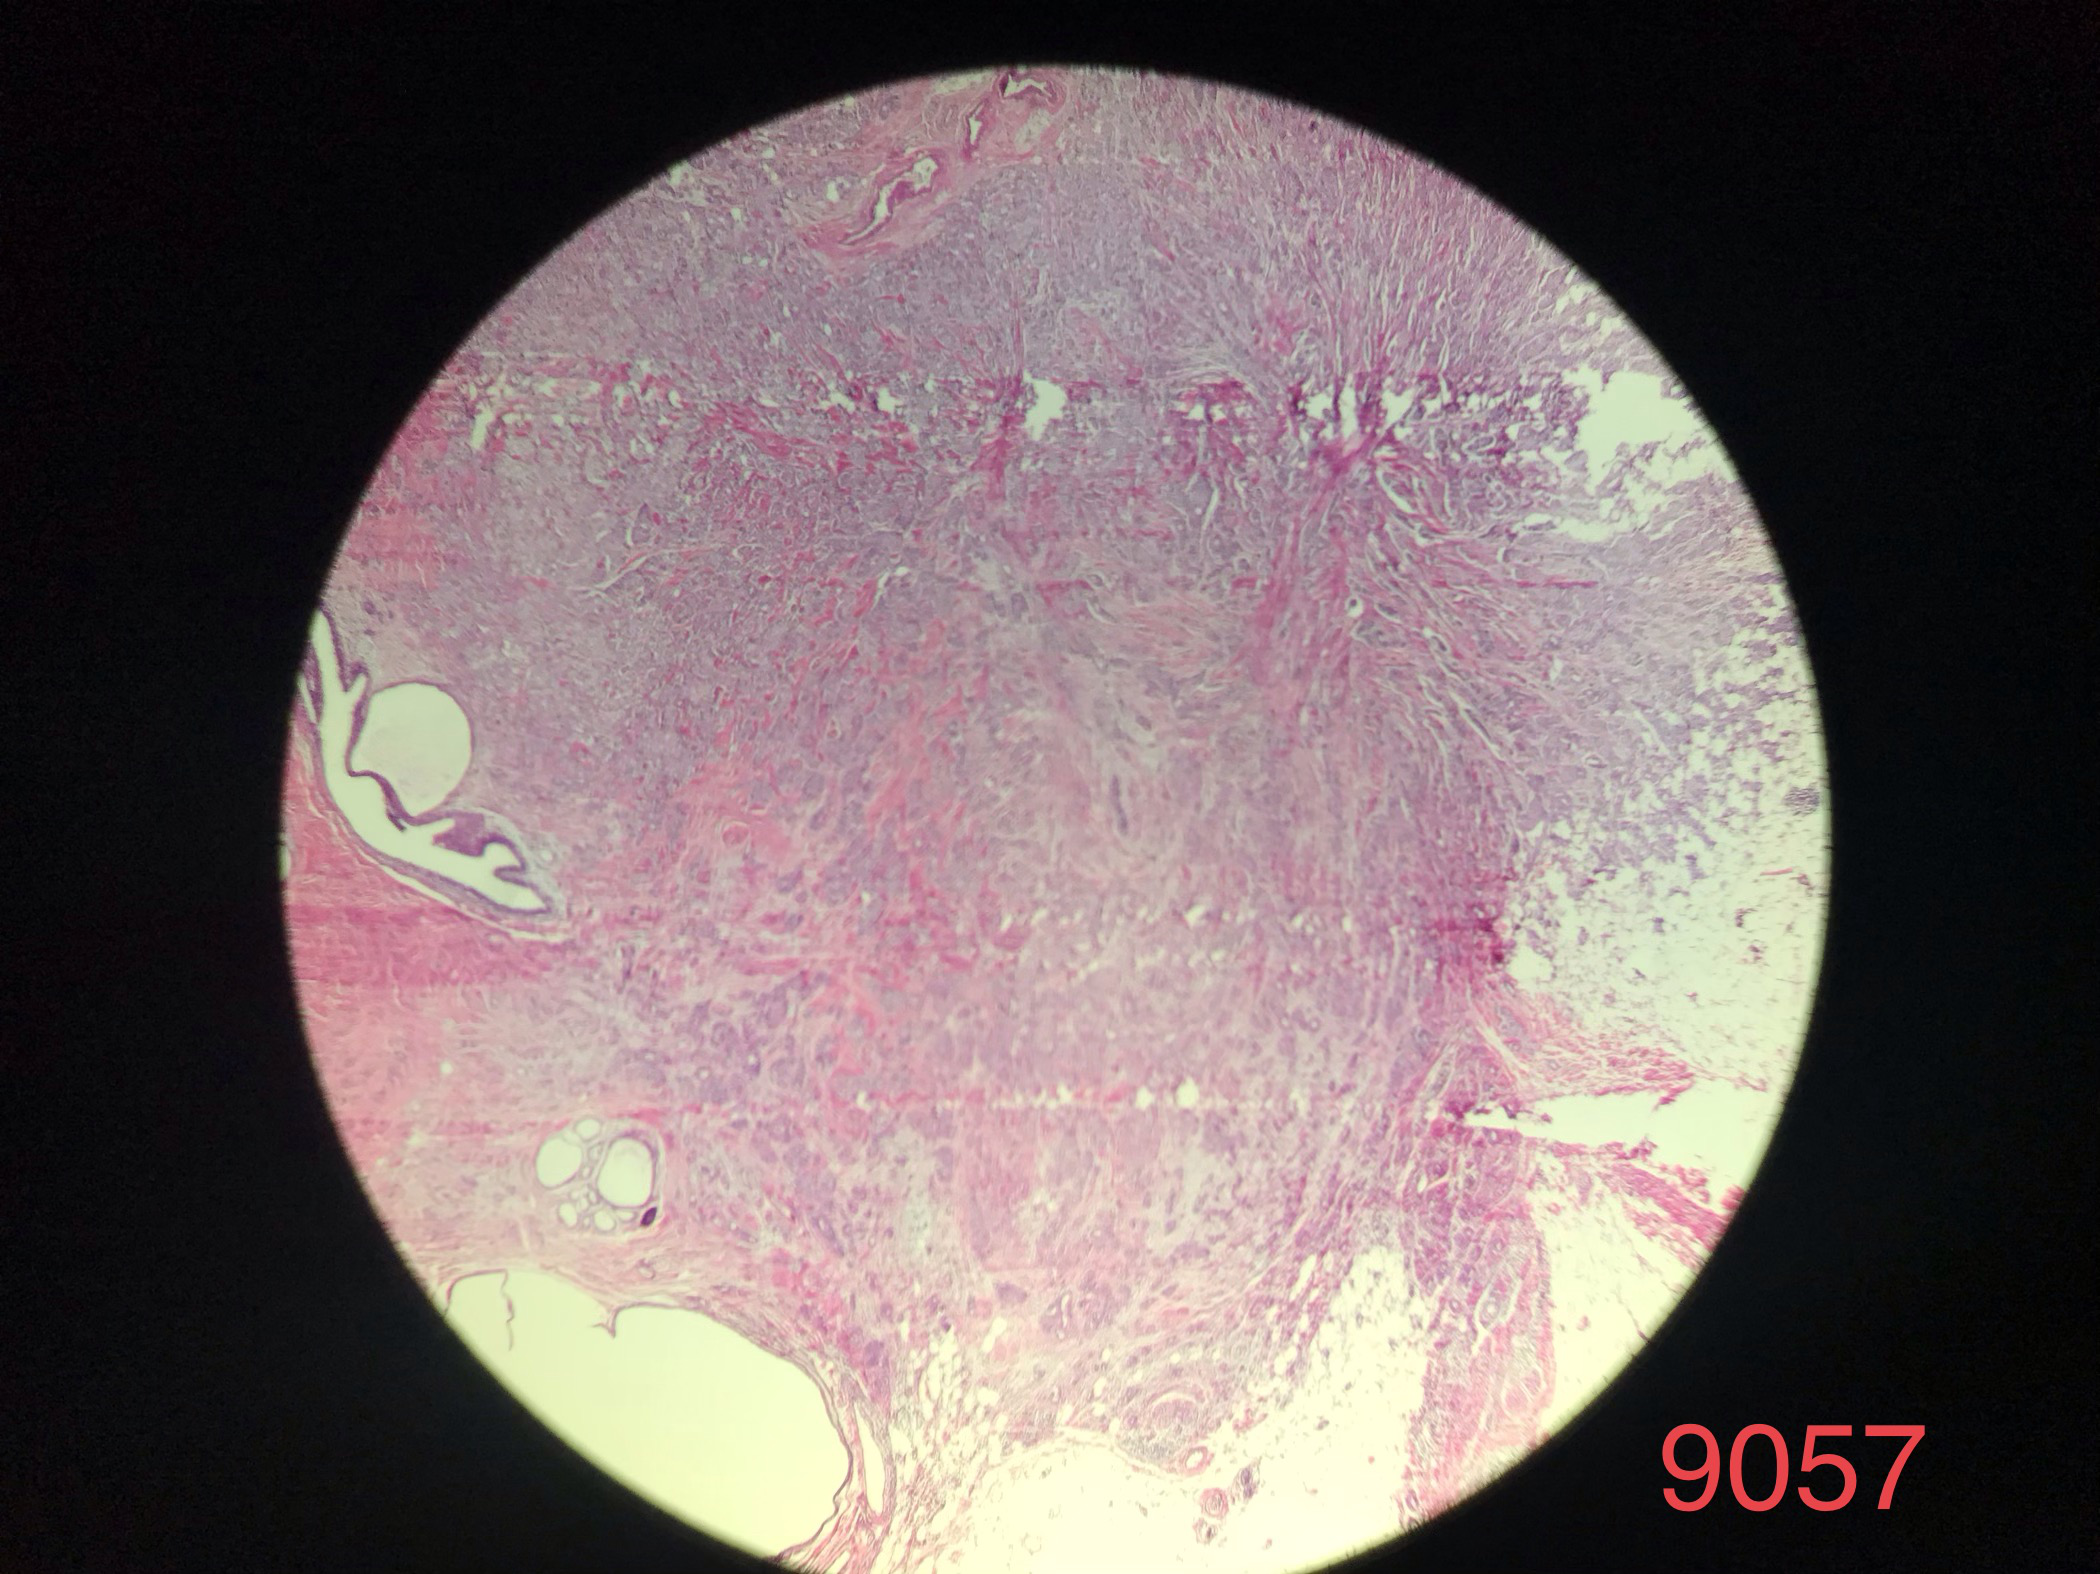

In [2]:
data_dir = 'D:/image_processing/Breast_Cancer'
sample_img = os.path.join(data_dir, 'Grade_1/01_BC_G1_9057_4x_1.JPG')
img = Image.open(sample_img)
img

In [3]:
info_dict = {
    "Filename": img.filename,
    "Image Size": img.size,
    "Image Height": img.height,
    "Image Width": img.width,
    "Image Format": img.format,
    "Image Mode": img.mode,
    "Frames in Image": getattr(img, "n_frames", 1)
}

for label,value in info_dict.items():
    print(f"{label:25}: {value}")

Filename                 : D:/image_processing/Breast_Cancer\Grade_1/01_BC_G1_9057_4x_1.JPG
Image Size               : (2100, 1574)
Image Height             : 1574
Image Width              : 2100
Image Format             : JPEG
Image Mode               : RGB
Frames in Image          : 1


## Augmenting the data

#### We have 259, 356, and 291 images for Grade_1, Grade_2, and Grade_3
#### So we need to augment out dataset

In [29]:
import Augmentor

p = Augmentor.Pipeline("D:/image_processing/Breast_Cancer/old_data")

Initialised with 906 image(s) found.
Output directory set to D:/image_processing/Breast_Cancer/old_data\output.

In [15]:
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.flip_left_right(probability=0.5)
p.flip_top_bottom(probability=0.5)
p.rotate_random_90(probability=0.5)
p.rotate180(probability=0.5)
p.sample(9000)

Processing <PIL.Image.Image image mode=RGB size=4032x3024 at 0x22B905B1D00>: 100%|██████████| 9000/9000 [20:24<00:00,  7.35 Samples/s]                  


#### Now we have 2512, 3470, and 3018 images for Grade_1, Grade_2, and Grade_3

## Splitting the data

In [16]:
import splitfolders
input_folder = 'D:/image_processing/Breast_Cancer/augmented_data/'
output_folder = 'D:/image_processing/Breast_Cancer/augmented_data/after_split/'

In [17]:
# Split ratio (70, 20, 10)
splitfolders.ratio(input_folder, output=output_folder, seed=123, ratio=(0.7, 0.2, 0.1), group_prefix=None)

Copying files: 9000 files [11:06, 13.50 files/s]


#### After Splitting, we have 6299, 1799, and 902 images for train, val, and test splits

## Pre-processing the images & Training the model

In [4]:
batch_size = 16
IMG_SHAPE = 384
base_dir = 'D:/image_processing/Breast_Cancer/augmented_data/after_split'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'

In [5]:
training_data = tf.keras.utils.image_dataset_from_directory(directory = train_dir,
                                                           labels = 'inferred',
                                                           label_mode='categorical',
                                                           batch_size=batch_size,
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           shuffle=True,
                                                           color_mode='rgb')

val_data = tf.keras.utils.image_dataset_from_directory(directory = val_dir,
                                                           labels = 'inferred',
                                                           label_mode='categorical',
                                                           batch_size=batch_size,
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')

test_data = tf.keras.utils.image_dataset_from_directory(directory = test_dir,
                                                           labels = 'inferred',
                                                           batch_size=batch_size,
                                                           label_mode='categorical',
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')

Found 6299 files belonging to 3 classes.
Found 1799 files belonging to 3 classes.
Found 902 files belonging to 3 classes.


In [6]:
@tf.function
def map_fn(img, label):
    image_height = IMG_SHAPE
    image_width = IMG_SHAPE
    img = tf.image.resize(img, [image_height, image_width])
    img /= 255
    return img, label

trian = training_data.map(map_fn)
val = val_data.map(map_fn)
test = test_data.map(map_fn)

In [27]:
# efficientnet_v2_imagenet21k_s model from tfhub

URL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMG_SHAPE, IMG_SHAPE, 3),
  trainable=False)
with tf.device(device_name=device):
    
    
    efficientnet_v2_s = tf.keras.Sequential([
      feature_extractor,
      tf.keras.layers.Dense(3)
    ])

    efficientnet_v2_s.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              20331360  
                                                                 
 dense_2 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 20,335,203
Trainable params: 3,843
Non-trainable params: 20,331,360
_________________________________________________________________


In [28]:
with tf.device(device_name=device):
    
    efficientnet_v2_s.compile(
      optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.001,
      momentum=0.9),
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])

In [37]:
EPOCHS = 20
with tf.device(device_name=device):
    
    history = efficientnet_v2_s.fit(trian,
                        epochs=EPOCHS,
                        validation_data=val)

Epoch 1/20
394/394 [==============================] - 201s 492ms/step - loss: 0.6738 - accuracy: 0.7293 - val_loss: 0.7408 - val_accuracy: 0.7015
Epoch 2/20
394/394 [==============================] - 198s 496ms/step - loss: 0.5786 - accuracy: 0.7633 - val_loss: 0.7027 - val_accuracy: 0.6948
Epoch 3/20
394/394 [==============================] - 273s 680ms/step - loss: 0.5528 - accuracy: 0.7744 - val_loss: 0.5490 - val_accuracy: 0.7843
Epoch 4/20
394/394 [==============================] - 289s 725ms/step - loss: 0.5625 - accuracy: 0.7703 - val_loss: 0.7214 - val_accuracy: 0.7015
Epoch 5/20
394/394 [==============================] - 259s 648ms/step - loss: 0.5144 - accuracy: 0.7889 - val_loss: 0.5823 - val_accuracy: 0.7521
Epoch 6/20
394/394 [==============================] - 258s 647ms/step - loss: 0.5058 - accuracy: 0.7922 - val_loss: 0.4809 - val_accuracy: 0.8032
Epoch 7/20
394/394 [==============================] - 253s 633ms/step - loss: 0.4894 - accuracy: 0.7989 - val_loss: 0.4738 -

In [7]:
loss, accuracy_d = model.evaluate(test, verbose=2)
print(" model, accuracy: {:5.2f}%".format(100 * accuracy_d))

57/57 - 34s - loss: 0.7904 - accuracy: 0.7084 - 34s/epoch - 589ms/step
 model, accuracy: 70.84%


In [ ]:
efficientnet_v2_s.save('D:/image_processing/Breast_Cancer/augmented_data/model_without_enhance.h5')

In [ ]:
# To load the model


# custom_objects = {'KerasLayer': hub.KerasLayer}
# model = tf.keras.models.load_model('D:/image_processing/Breast_Cancer/augmented_data/model_without_enhance.h5', custom_objects=custom_objects)

### This model is not good enough so we will train on a larger model with larger image resolution

In [35]:
batch_size = 16
IMG_SHAPE = 512
base_dir = 'D:/image_processing/Breast_Cancer/augmented_data/after_split'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'

In [36]:
training_data = tf.keras.utils.image_dataset_from_directory(directory = train_dir,
                                                           labels = 'inferred',
                                                           label_mode='categorical',
                                                           batch_size=batch_size,
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           shuffle=True,
                                                           color_mode='rgb')

val_data = tf.keras.utils.image_dataset_from_directory(directory = val_dir,
                                                           labels = 'inferred',
                                                           label_mode='categorical',
                                                           batch_size=batch_size,
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')

test_data = tf.keras.utils.image_dataset_from_directory(directory = test_dir,
                                                           labels = 'inferred',
                                                           batch_size=batch_size,
                                                           label_mode='categorical',
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')

Found 6299 files belonging to 3 classes.
Found 1799 files belonging to 3 classes.
Found 902 files belonging to 3 classes.


In [37]:
@tf.function
def map_fn(img, label):
    image_height = IMG_SHAPE
    image_width = IMG_SHAPE
    img = tf.image.resize(img, [image_height, image_width])
    img /= 255
    return img, label

trian = training_data.map(map_fn)
val = val_data.map(map_fn)
test = test_data.map(map_fn)

In [18]:
# efficientnet_v2_imagenet21k_ft1k_xl model from tfhub

URL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMG_SHAPE, IMG_SHAPE, 3),
  trainable=False)
with tf.device(device_name=device):
    
    
    model2 = tf.keras.Sequential([
      feature_extractor,
      tf.keras.layers.Dense(3)
    ])

    model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 207,619,675
Trainable params: 3,843
Non-trainable params: 207,615,832
_________________________________________________________________


In [19]:
with tf.device(device_name=device):
    
    model2.compile(
      optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.001,
      momentum=0.9),
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])

In [20]:
EPOCHS = 20
with tf.device(device_name=device):
    
    history = model2.fit(trian,
                        epochs=EPOCHS,
                        validation_data=val)

Epoch 1/20
394/394 [==============================] - 1171s 3s/step - loss: 0.9276 - accuracy: 0.5571 - val_loss: 0.8456 - val_accuracy: 0.5987
Epoch 2/20
394/394 [==============================] - 1063s 3s/step - loss: 0.7790 - accuracy: 0.6614 - val_loss: 0.7290 - val_accuracy: 0.6843
Epoch 3/20
394/394 [==============================] - 1071s 3s/step - loss: 0.7315 - accuracy: 0.6787 - val_loss: 0.7176 - val_accuracy: 0.6804
Epoch 4/20
394/394 [==============================] - 1074s 3s/step - loss: 0.6730 - accuracy: 0.7181 - val_loss: 0.6674 - val_accuracy: 0.7287
Epoch 5/20
394/394 [==============================] - 1074s 3s/step - loss: 0.6504 - accuracy: 0.7279 - val_loss: 0.6668 - val_accuracy: 0.7121
Epoch 6/20
394/394 [==============================] - 1076s 3s/step - loss: 0.6365 - accuracy: 0.7355 - val_loss: 0.6585 - val_accuracy: 0.7126
Epoch 7/20
394/394 [==============================] - 1074s 3s/step - loss: 0.6168 - accuracy: 0.7517 - val_loss: 0.6140 - val_accuracy:

In [21]:
loss, accuracy_d = model2.evaluate(test, verbose=2)
print(" model, accuracy: {:5.2f}%".format(100 * accuracy_d))

57/57 - 131s - loss: 0.4729 - accuracy: 0.8282 - 131s/epoch - 2s/step
 model, accuracy: 82.82%


In [22]:
model2.save('D:/image_processing/Breast_Cancer/augmented_data/model_2.h5')

### This model is better than the previous one so we will continue to the next part

## Image Enhancement

In [30]:
# Enhancing test set images 

p_test = Augmentor.Pipeline("D:/image_processing/Breast_Cancer/augmented_data/after_split/test")

Initialised with 902 image(s) found.
Output directory set to D:/image_processing/Breast_Cancer/augmented_data/after_split/test\output.

In [31]:
p_test.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.6)
p_test.random_color(probability=0.5, min_factor=0.7, max_factor=1.6)
p_test.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.6)
p_test.process()

Processing <PIL.Image.Image image mode=RGB size=960x1280 at 0x18D4C681D00>: 100%|██████████| 902/902 [02:01<00:00,  7.45 Samples/s]                   


In [38]:
new_test_dir = os.path.join(base_dir, 'test/test_enh')
new_test_data = tf.keras.utils.image_dataset_from_directory(directory = new_test_dir,
                                                           labels = 'inferred',
                                                           batch_size=batch_size,
                                                           label_mode='categorical',
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')
new_test = new_test_data.map(map_fn)

Found 902 files belonging to 3 classes.


In [39]:
loss, accuracy_d = model2.evaluate(new_test, verbose=2)
print(" model, accuracy: {:5.2f}%".format(100 * accuracy_d))

57/57 - 115s - loss: 0.6428 - accuracy: 0.7550 - 115s/epoch - 2s/step
 model, accuracy: 75.50%


#### The Accuracy dropped from 82.82% to 75.50%

### Applying filter

In [40]:
p_test2 = Augmentor.Pipeline("D:/image_processing/Breast_Cancer/augmented_data/after_split/test/test_enh")

Initialised with 902 image(s) found.
Output directory set to D:/image_processing/Breast_Cancer/augmented_data/after_split/test/test_enh\output.

In [41]:
p_test2.histogram_equalisation(probability=1)
p_test2.process()

Processing <PIL.Image.Image image mode=RGB size=960x1280 at 0x18D4C86EB20>: 100%|██████████| 902/902 [00:48<00:00, 18.70 Samples/s] 


In [42]:
new_test_dir2 = os.path.join(base_dir, 'test/test_filter')
new_test_data2 = tf.keras.utils.image_dataset_from_directory(directory = new_test_dir2,
                                                           labels = 'inferred',
                                                           batch_size=batch_size,
                                                           label_mode='categorical',
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')
new_test2 = new_test_data2.map(map_fn)

Found 902 files belonging to 3 classes.


In [43]:
loss, accuracy_d = model2.evaluate(new_test2, verbose=2)
print(" model, accuracy: {:5.2f}%".format(100 * accuracy_d))

57/57 - 116s - loss: 1.2673 - accuracy: 0.5532 - 116s/epoch - 2s/step
 model, accuracy: 55.32%


#### The Accuracy dropped from 75.50% to 55.32% after applying the filter. We will check the images to see why

Original Image


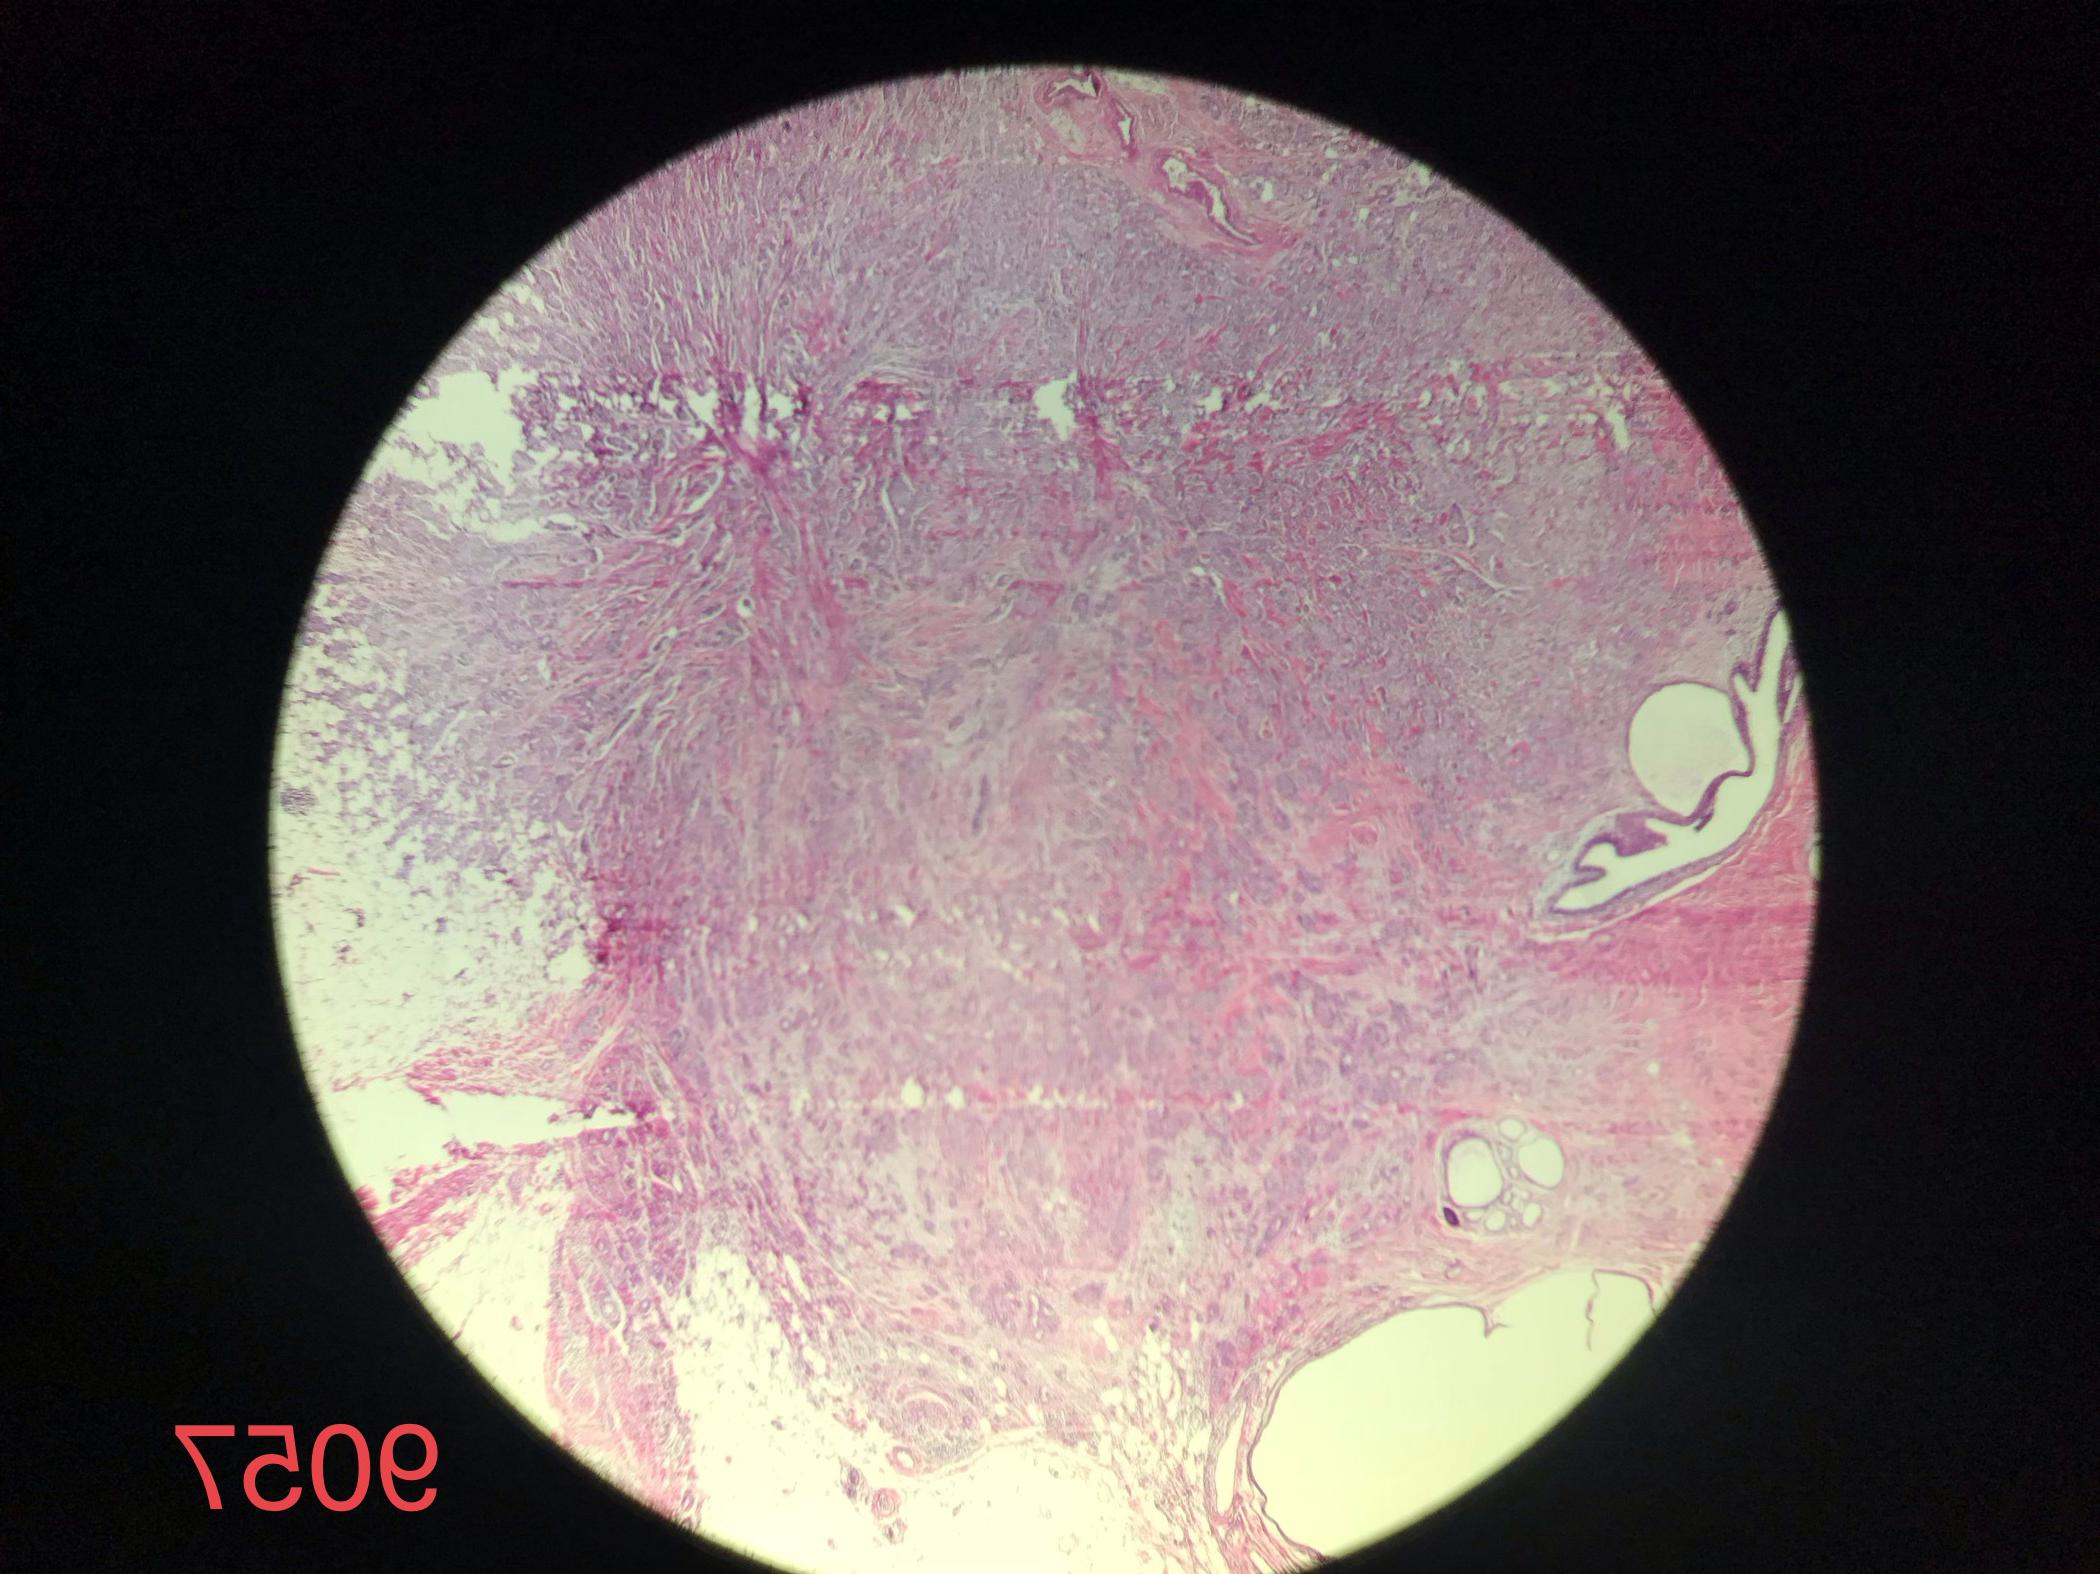

Enhanced Image


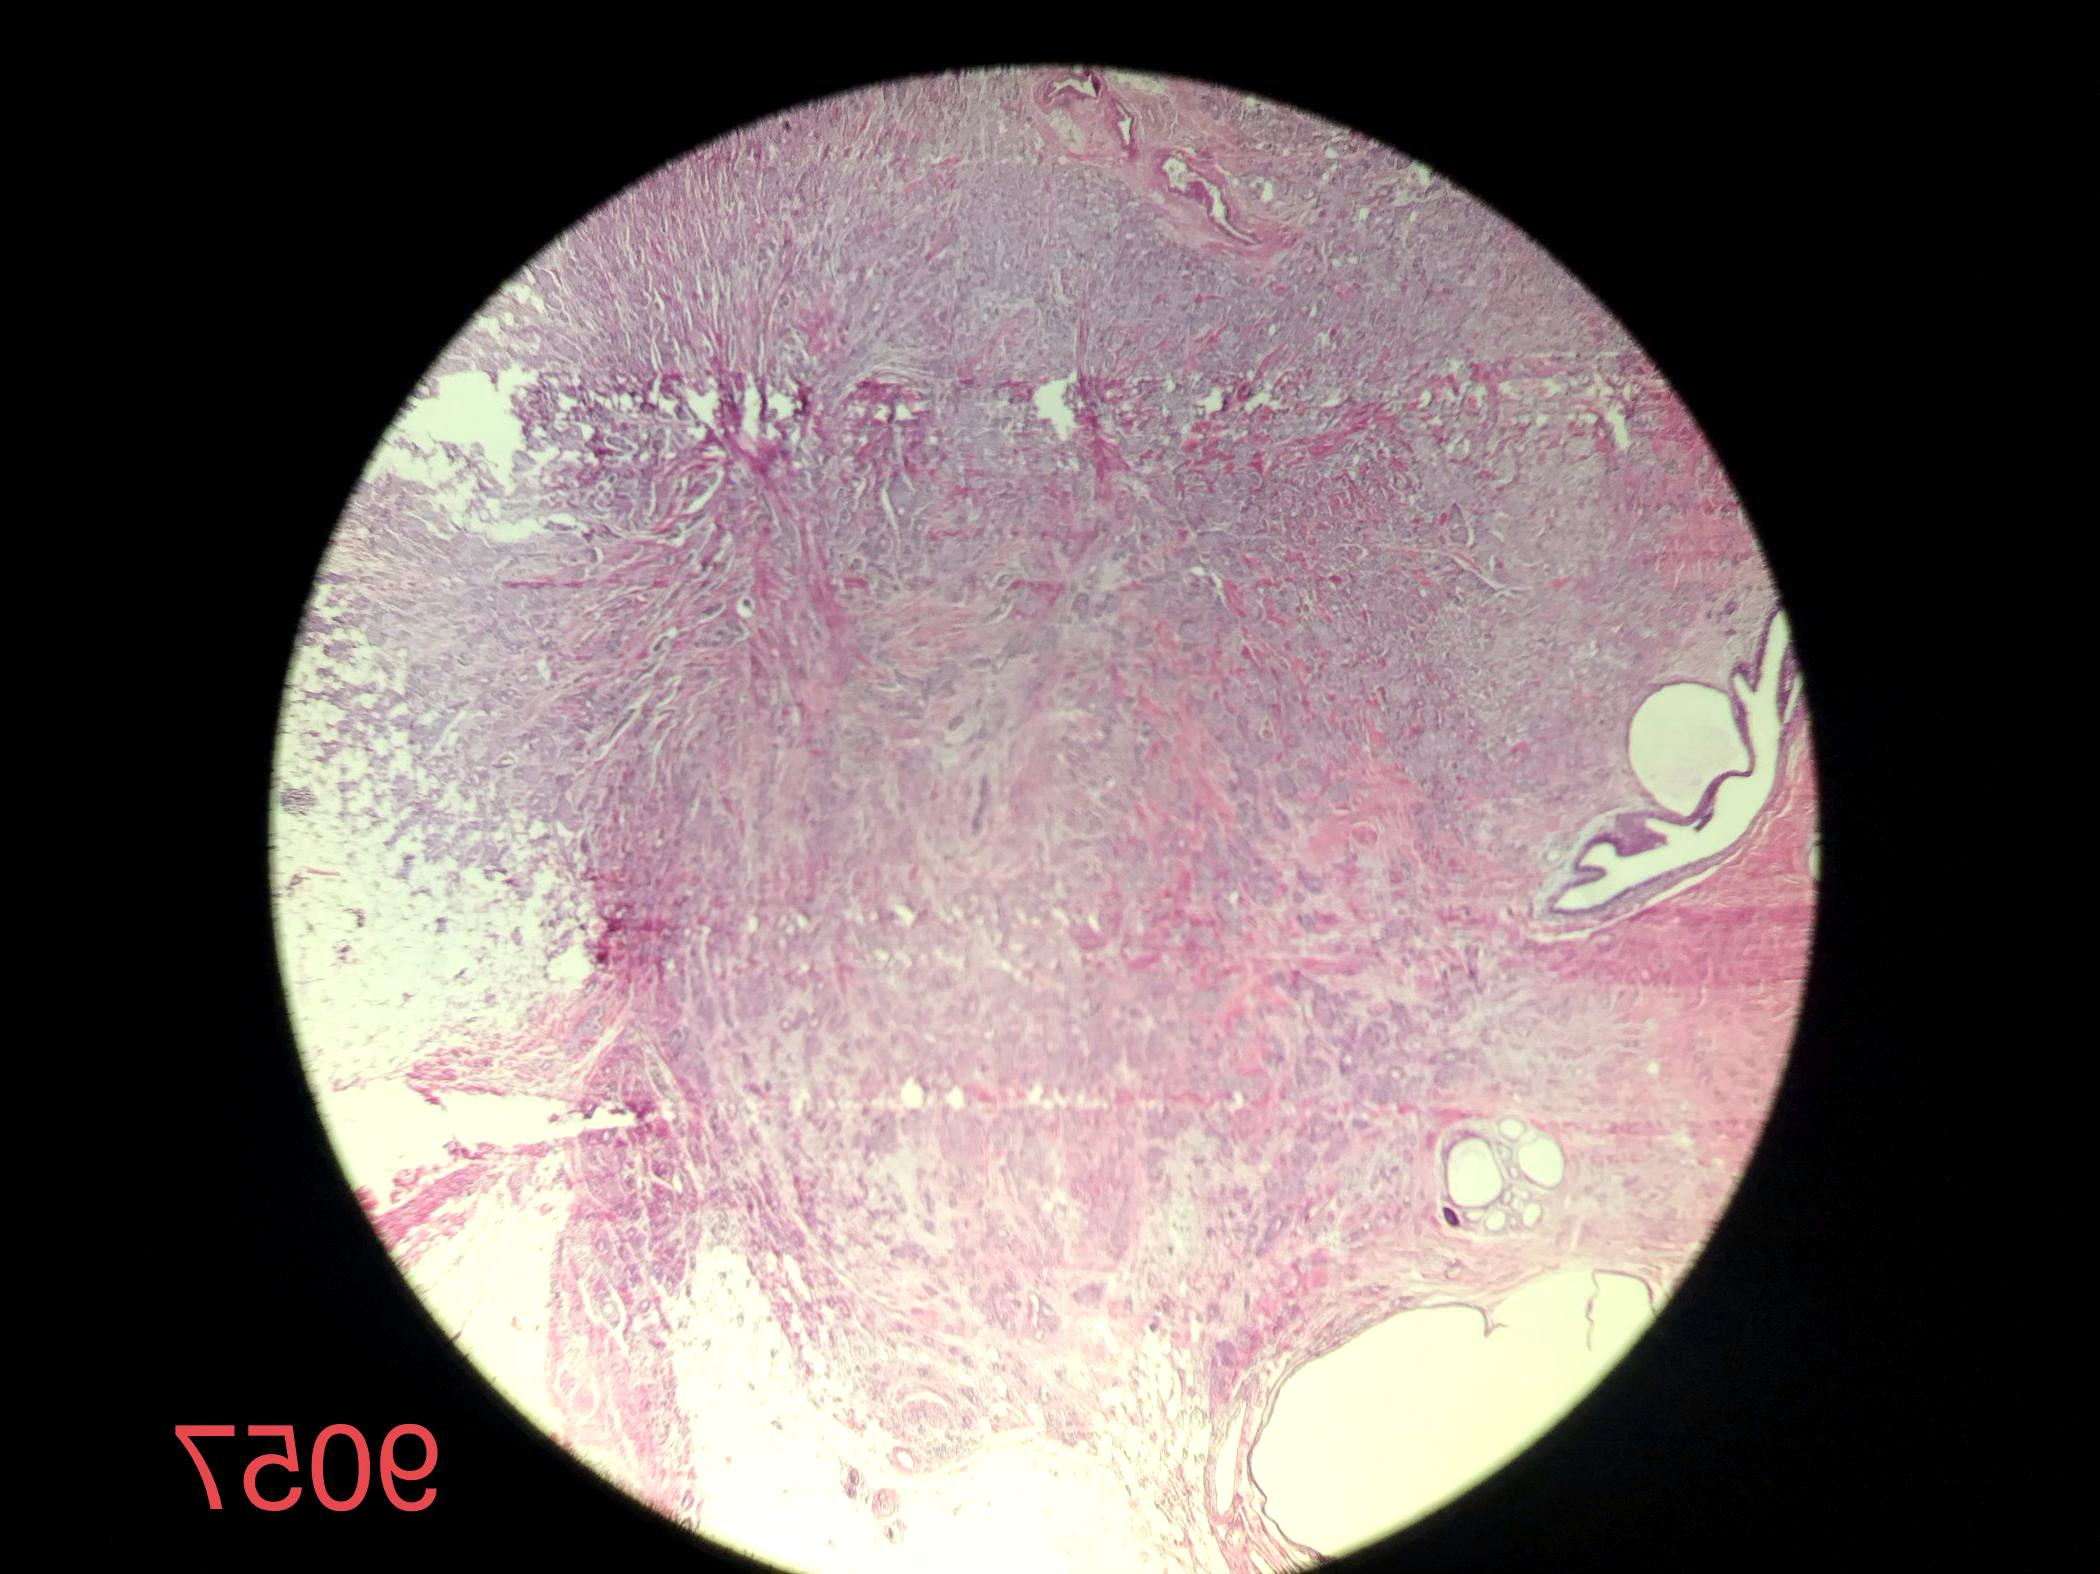

Filtered Image


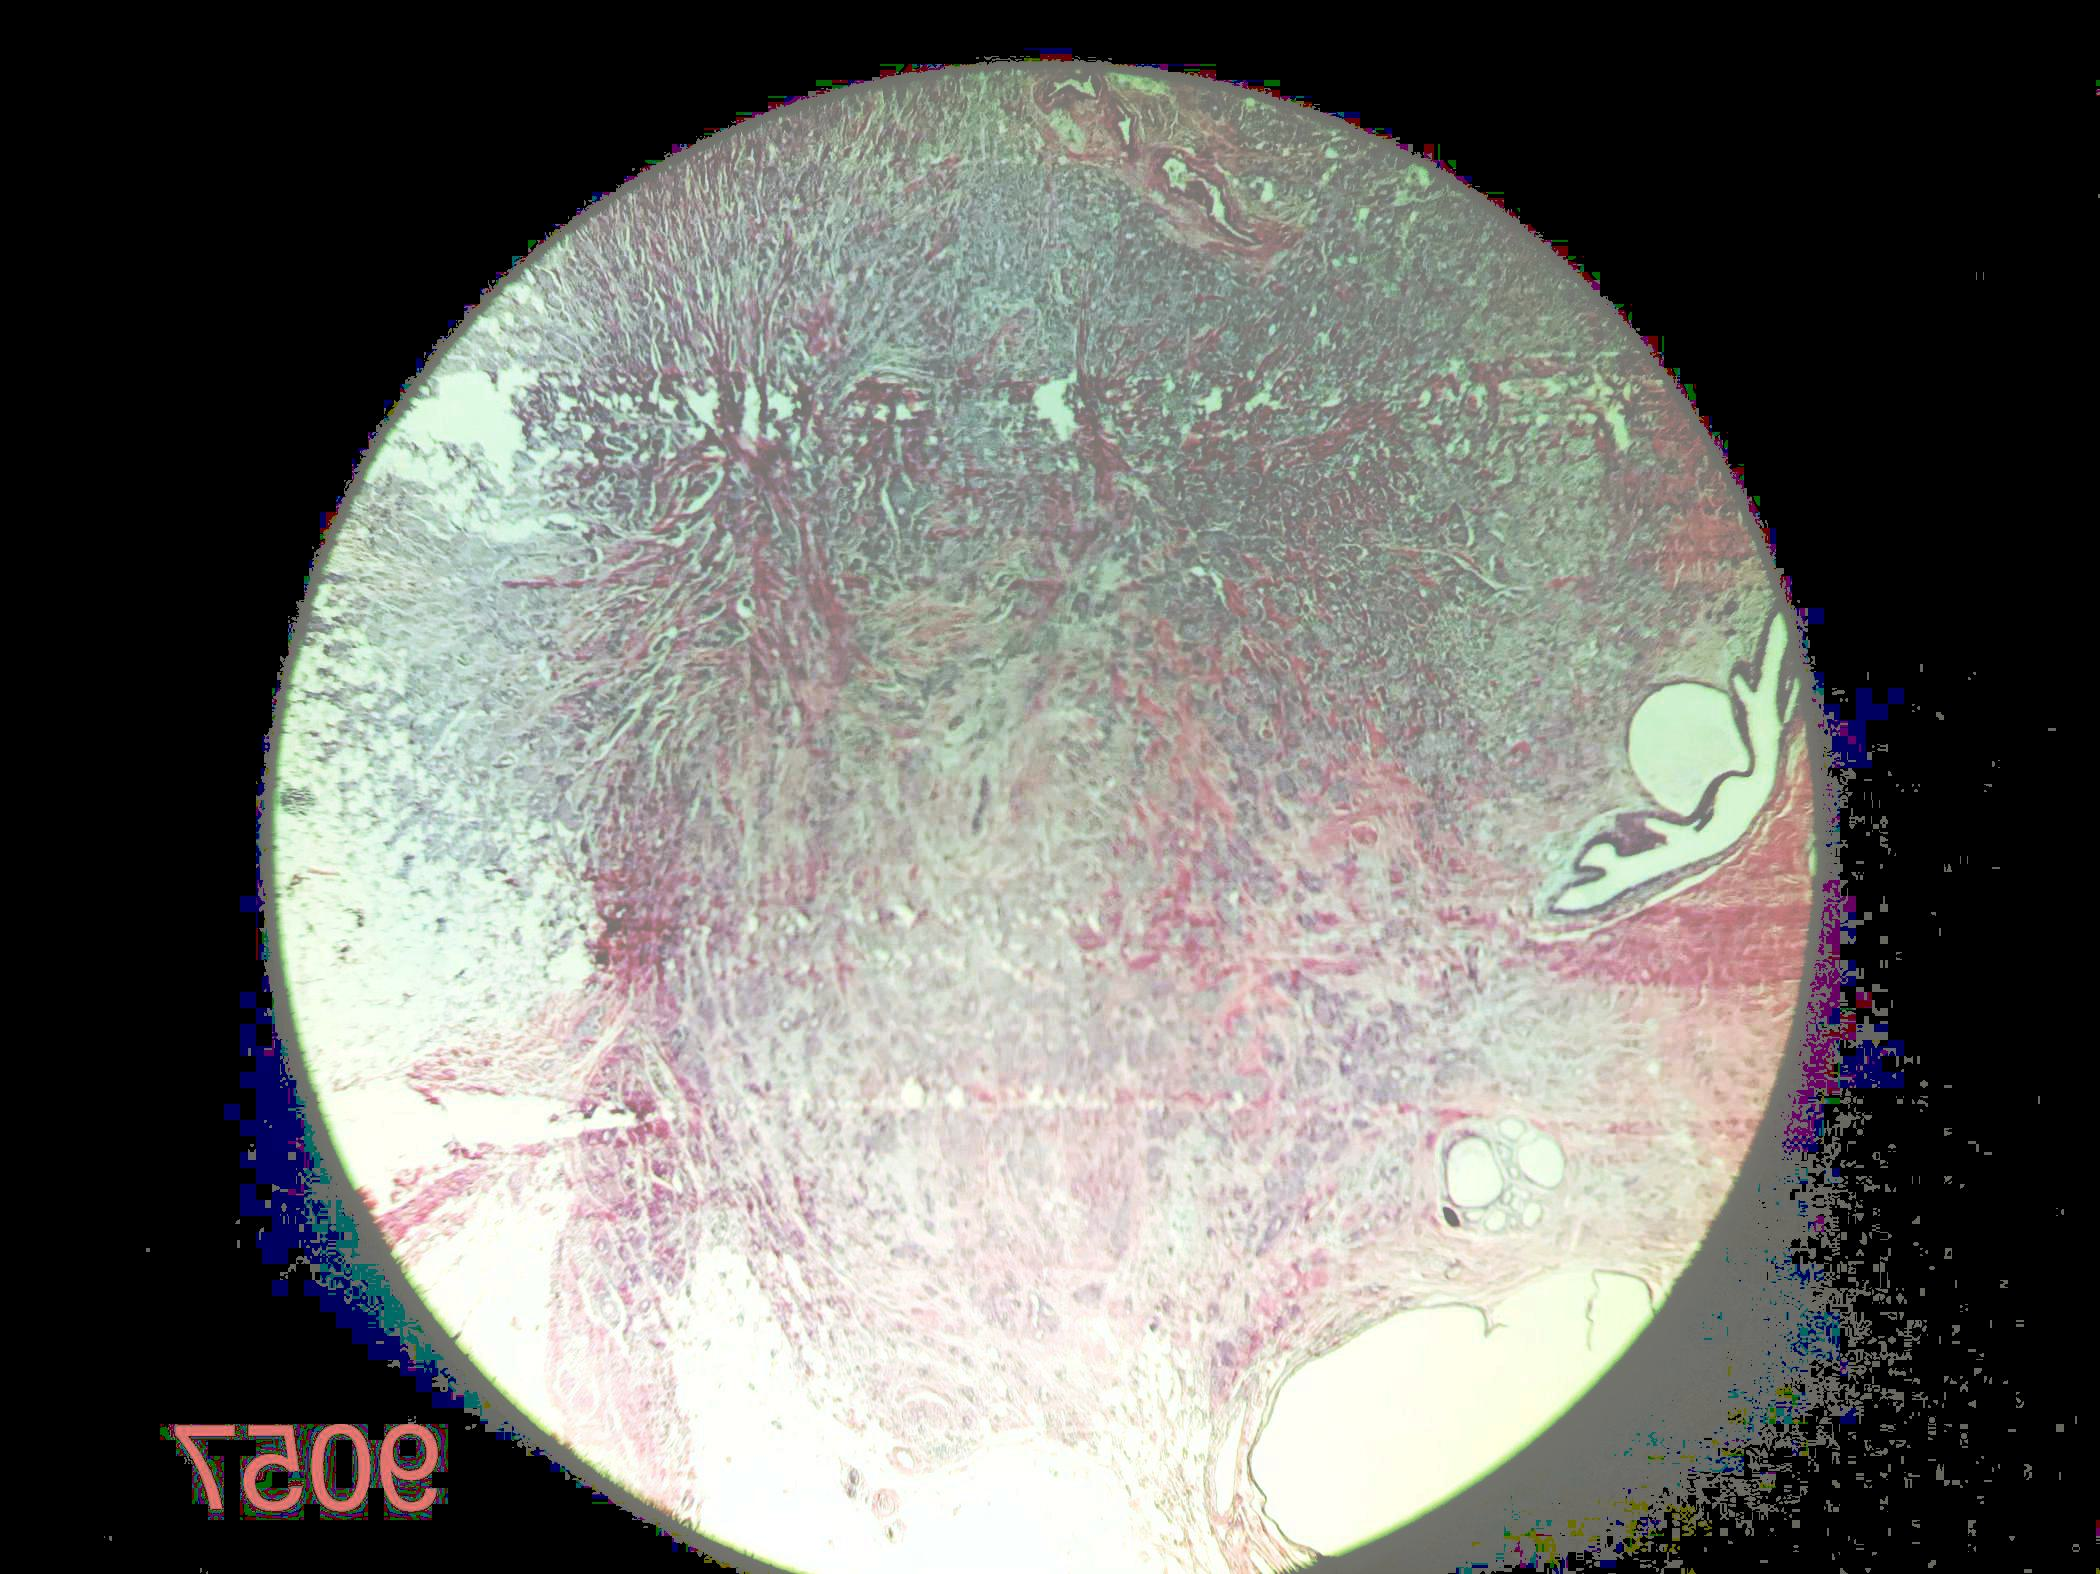

In [51]:
from IPython.display import Image as Im
from IPython.display import display


data_dir = 'D:/image_processing/Breast_Cancer/augmented_data/after_split/test'
original_img = os.path.join(data_dir, 'Grade_1/Grade_1_original_01_BC_G1_9057_4x_1.JPG_77a6d077-a2c7-4263-919b-b02687feb00a.JPG')
enhanced_img = os.path.join(data_dir, 'test_enh/Grade_1/Grade_1_original_Grade_1_original_01_BC_G1_9057_4x_1.JPG_77a6d077-a2c7-4263-919b-b02687feb00a.JPG_91d6fe41-8ef9-4a2c-9901-9bc70723b6c9.JPG')
filtered_ima = os.path.join(data_dir, 'test_filter/Grade_1/Grade_1_original_Grade_1_original_Grade_1_original_01_BC_G1_9057_4x_1.JPG_77a6d077-a2c7-4263-919b-b02687feb00a.JPG_91d6fe41-8ef9-4a2c-9901-9bc70723b6c9.JPG_0d2b6d63-ce51-47b9-a683-8406e211e1ff.JPG')


x = Im(original_img) 
y = Im(enhanced_img)
z = Im(filtered_ima)
print('Original Image')
display(x)
print('Enhanced Image')
display(y)
print('Filtered Image')
display(z)

## Conclusion

### Filtering the Enhanced images made the images colour change which was one of the features the model trained on, So the accuracy dropped after applying the filter. 
### We can Furthur retrain the model on the enhanced images and we may get slightely better results. 